In [1]:
# Get Libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd 
import plotly.express as px
from matplotlib import pyplot as plt
from pandas import datetime
import statsmodels.api as sm
from pandas.tseries.offsets import DateOffset


In [2]:
df = pd.read_csv("C://Users/Joe/Desktop/GC_Traffic.txt", sep='\t')
df.Date = df.Date.apply(lambda x: x.split()[0]).apply(lambda x: datetime.strptime(x,'%d/%m/%y'))
df.columns = ['Date','Sales']
df.set_index('Date', inplace=True)
df.tail(10).transpose()

Date,2019-06-29,2019-06-30,2019-07-01,2019-07-02,2019-07-03,2019-07-04,2019-07-05,2019-07-06,2019-07-07,2019-07-08
Sales,2655321,2279690,2438360,2495127,2531195,2174217,2530250,2510980,2032842,2291760


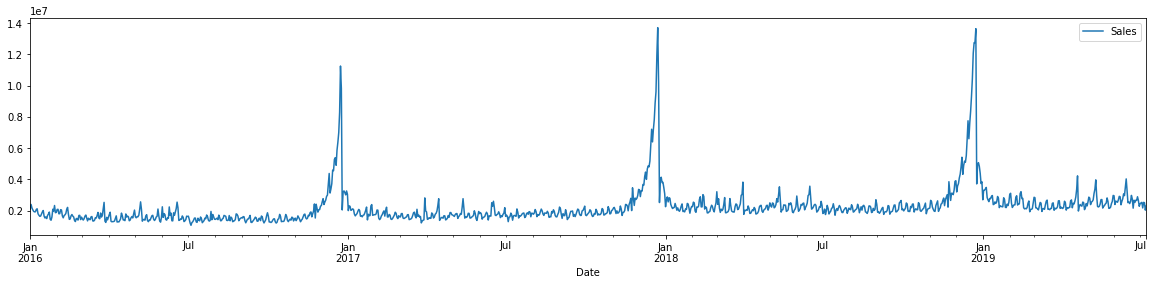

In [3]:
df.plot(figsize=(20,4))

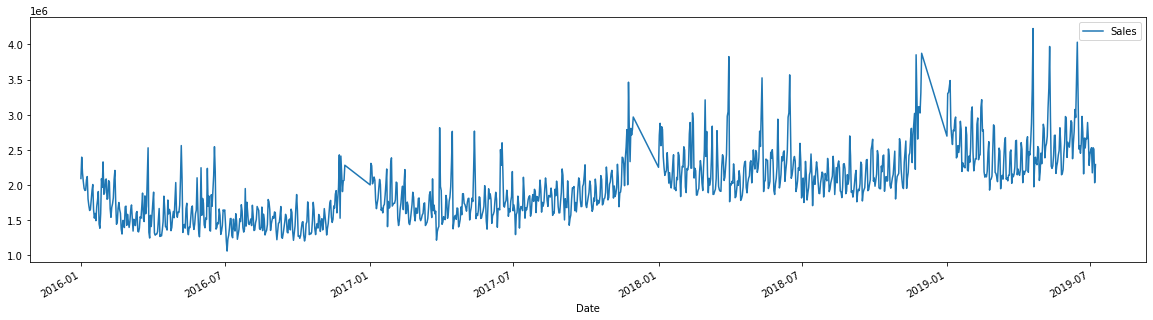

In [4]:
df11 = df[df.index.month<=11]
df12 = df[df.index.month==12]

df11.plot(figsize=(20,5))

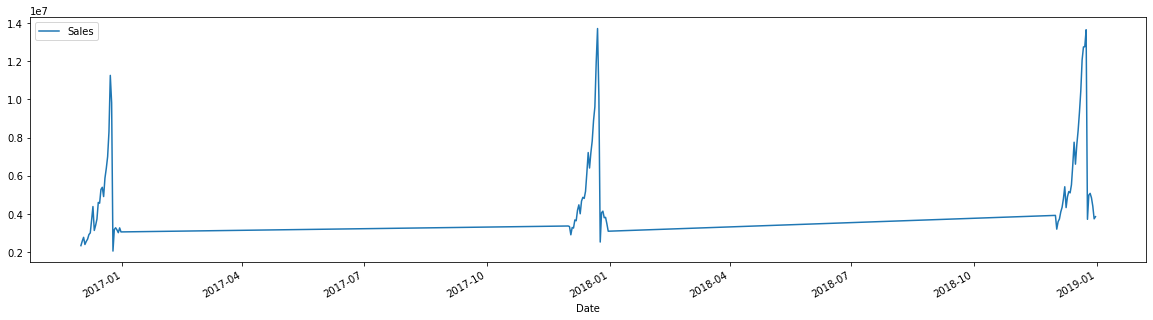

In [5]:
df12.plot(figsize=(20,5))

#### Confirm Data Stationary using Auto-Correlation Function

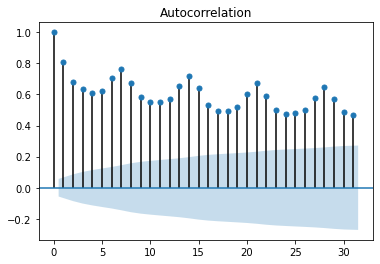

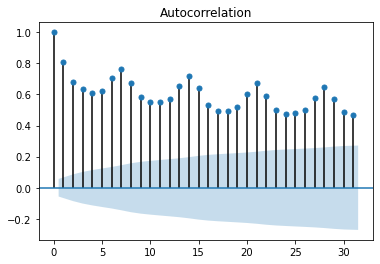

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df11)

#### Check Data Stationary using Augmented Dickey-Fuller (ADF) Test

In [7]:
from statsmodels.tsa.stattools import adfuller

def check_stationary(df_column):
    values = adfuller(df_column)
    lables = ['ADF Stattistics', 'p-Value', 'Lags Used', 'Observations']
    for label, value in zip(lables, values):
        print(label, ':', str(value))
    
    if values[1] <= 0.05:
        print('Data Information : Stationary Data')
        return 1
    else:
        print('Data Information : Non-Stationary Data')
        return 0

check_stationary(df11)

ADF Stattistics : -2.296972087245209
p-Value : 0.17294639342569873
Lags Used : 22
Observations : 1169
Data Information : Non-Stationary Data


0

#### Convert Non-Stationary Points to Stationary Points

ADF Stattistics : -9.855450895764504
p-Value : 4.371852441181632e-17
Lags Used : 23
Observations : 1167
Data Information : Stationary Data
Lag found = 1


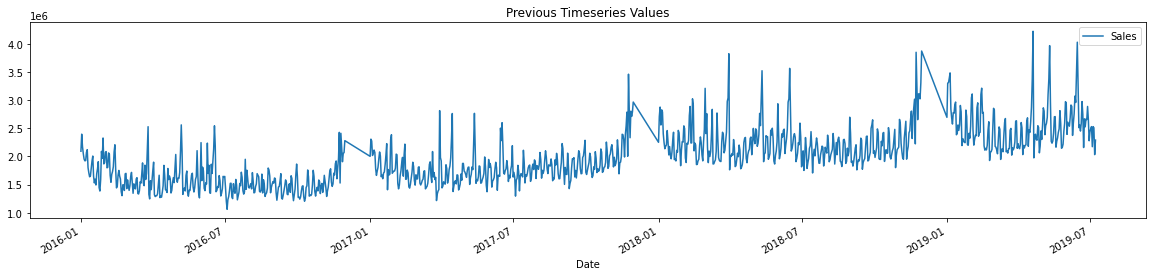

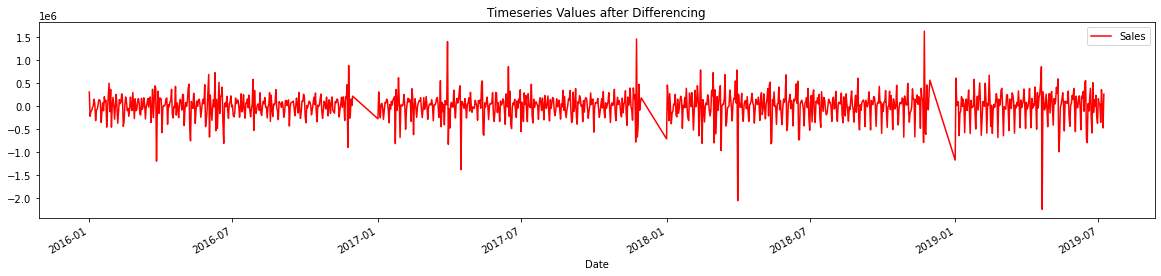

In [8]:
d_value = 1
while True:    
    df11_temp = df11.diff(periods=d_value)
    if check_stationary(df11_temp[d_value:]) == 1: # Stationary
        break
    d_value += 1
    
    if d_value > 366:
        print('Annual Limit Crossed !!')
        break

print('Lag found =', d_value)

df11_s = df11.diff(periods=d_value)

df11.plot(title='Previous Timeseries Values',figsize=(20,4))
df11_s.plot(title='Timeseries Values after Differencing',color='red',figsize=(20,4))
plt.show()

ADF Stattistics : -3.2041557225134794
p-Value : 0.01974538634598597
Lags Used : 0
Observations : 92
Data Information : Stationary Data


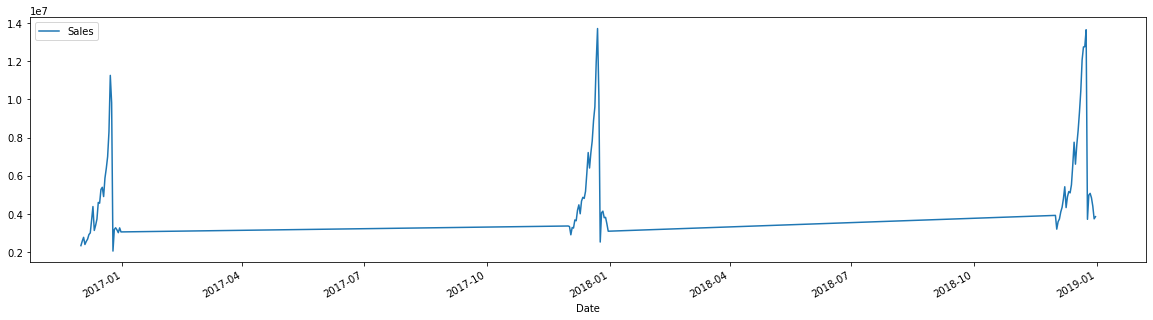

In [9]:
check_stationary(df12)
df12.plot(figsize=(20,5))

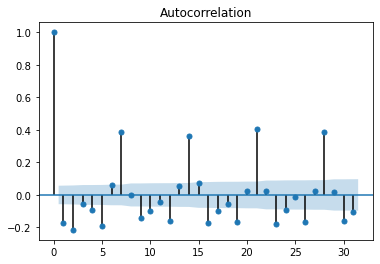

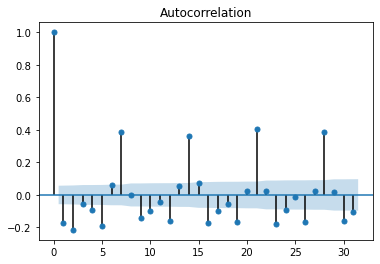

In [10]:
plot_acf(df11_s[1:])

- Exponential Decay i.e. Stationary Data
- q value = From 1 to 3 preferably (Based on blue region)

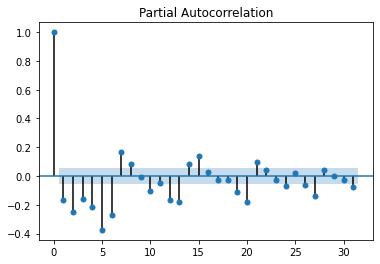

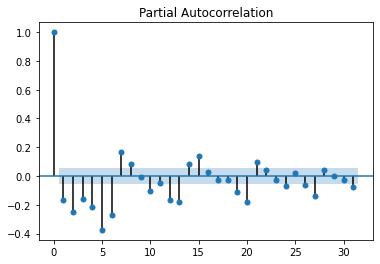

In [11]:
plot_pacf(df11_s[1:])

- Exponential Decay i.e. Stationary Data
- p value = Start from 1 to 9 or 11 preferably (Based on blue region)

## Predicitve Modeling

In [12]:
df11_2016, df12_2016 = df11[df11.index.year==2016], df12[df12.index.year==2016]
df11_2017, df12_2017 = df11[df11.index.year==2017], df12[df12.index.year==2017]
df11_2018, df12_2018 = df11[df11.index.year==2018], df12[df12.index.year==2018]
df11_2019, df12_2019 = df11[df11.index.year==2019], df12[df12.index.year==2019]

print('Shapes',
      '\n df11_2016 =', df11_2016.shape, '\t df12_2016 =', df12_2016.shape,
      '\n df11_2017 =', df11_2017.shape, '\t df12_2017 =', df12_2017.shape,
      '\n df11_2018 =', df11_2018.shape, '\t df12_2018 =', df12_2018.shape,
      '\n df11_2019 =', df11_2019.shape, '\t df12_2019 =', df12_2019.shape )
     

Shapes 
 df11_2016 = (335, 1) 	 df12_2016 = (31, 1) 
 df11_2017 = (334, 1) 	 df12_2017 = (31, 1) 
 df11_2018 = (334, 1) 	 df12_2018 = (31, 1) 
 df11_2019 = (189, 1) 	 df12_2019 = (0, 1)


#### Plot prediction of successive year using AR, ARIMA, S-ARIMA Model

In [13]:
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

def predict_ar(dfs, start_point, end_point):    
    if dfs.shape[0]==0:
        return []
    else:
        model_ar = AR(dfs)
        model_ar_fit = model_ar.fit()
        return model_ar_fit.predict(start = start_point, end = end_point)
    
def predict_arima(dfs, od, start_point, end_point):    
    if dfs.shape[0]==0:
        return []
    else:
        model_arima = ARIMA(dfs, order = od)
        model_arima_fit = model_arima.fit()
        return model_arima_fit.predict(start = start_point, end = end_point, dynamic=True)

    
def predict_sarima(dfs, od, start_point, end_point):
    if dfs.shape[0]==0:
        return []
    else:    
        s_arima_model = sm.tsa.statespace.SARIMAX(dfs, order=od, seasonal_orders=(od[0], od[1], od[2], 1))
        s_arima_fit = s_arima_model.fit()
        print(s_arima_fit.aic)
        return s_arima_fit.predict(start = start_point, end = end_point)#dynamic=True



def plot_next_year(a11, a12, b11, b12, n_days, model_type, od):
    
    # Setting date index
    temp_df = pd.DataFrame()           
    
    # Setting Prediction Scres
    sp, ep = a11.shape[0], a11.shape[0] + 365 - 31 - 1    
    if model_type==1:           
        temp_df['predict'] = list(predict_ar(a11, sp, ep)) + list(predict_ar(a12,  31,  61))
    if model_type==2:       
        temp_df['predict'] = list(predict_arima(a11, od, sp, ep)) + list(predict_arima(a12, od, 31,  61))
    else:
        temp_df['predict'] = list(predict_sarima(a11, od, sp, ep)) + list(predict_sarima(a12, od, 31,  61))
        
    temp_df['date'] = [b11.index[0] + DateOffset(days = x) for x in range(0, n_days)]
    temp_df.set_index('date', inplace=True)    
        
    # Setting Actual Scores    
    lst = list(b11.Sales) + list(b12.Sales)    
    if len(lst) < temp_df.shape[0]:
        lst = lst + [np.nan]*(temp_df.shape[0] - len(lst))
    temp_df['actual' ] = lst
                
    # Plotting Actual vs Predicted Values
    temp_df[['actual','predict']].plot(title='Predicting Next Year', figsize=(20,5))
    plt.show()
    

C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


10529.262250072
1044.3473263086453


C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


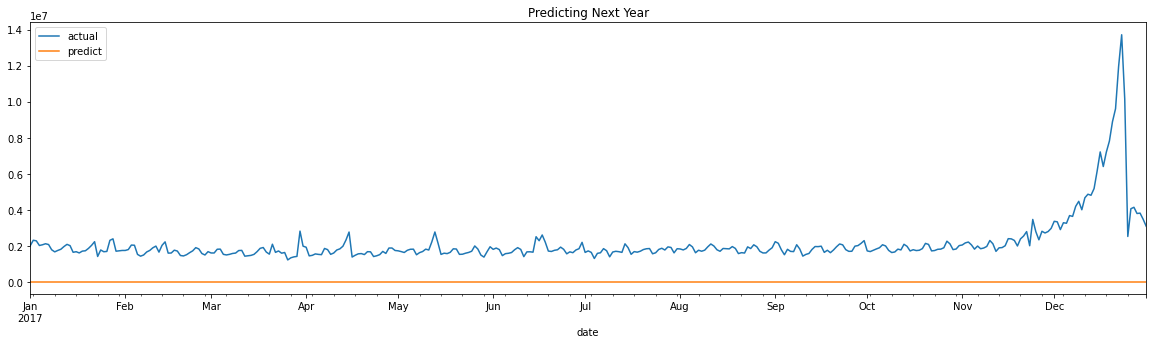

In [14]:
plot_next_year(df11_2016, df12_2016, df11_2017, df12_2017, 365, 1, (0, 0, 0))

C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so

21121.49355785566
2103.0853665928503


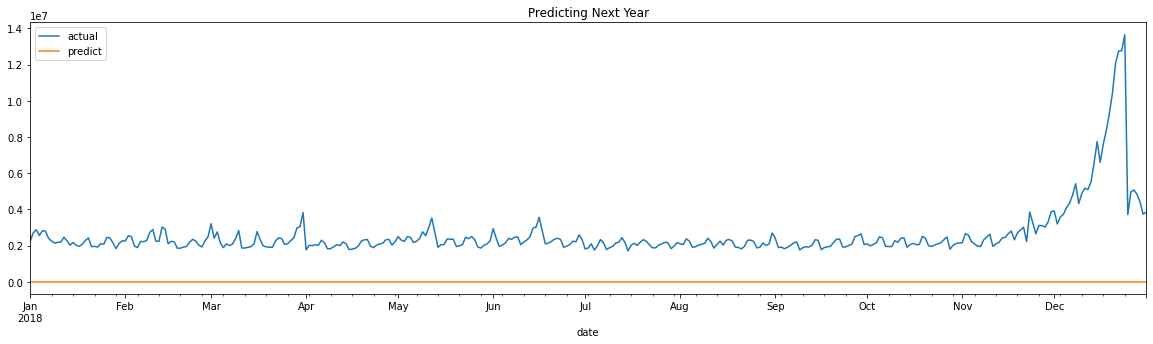

In [15]:
df11_2017t   = df11_2016.append(df11_2017)
df12_2017t   = df12_2016.append(df12_2017)

plot_next_year(df11_2017t, df12_2017t, df11_2018, df12_2018, 365, 1, (0, 0, 0))

C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so

31879.98533298063
3170.9675699213403


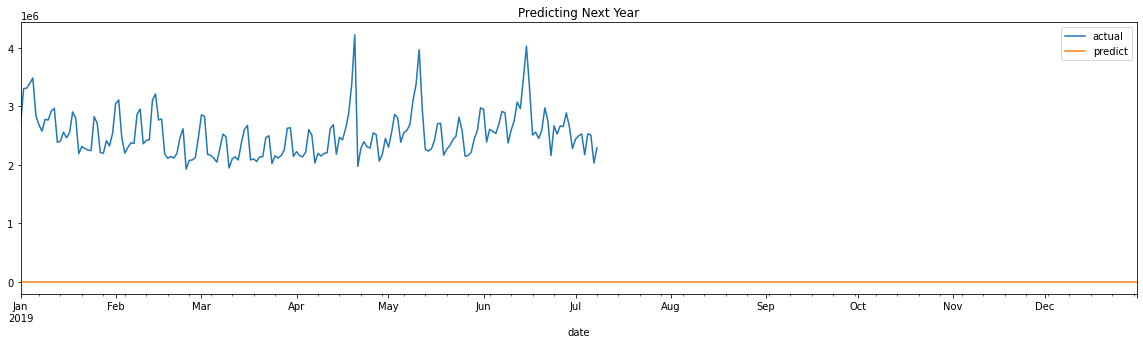

In [16]:
df11_2018t   = df11_2016.append(df11_2017)
df11_2018t   = df11_2018t.append(df11_2018)

df12_2018t   = df12_2016.append(df12_2017)
df12_2018t   = df12_2018t.append(df12_2018)

plot_next_year(df11_2018t, df12_2018t, df11_2019, df12_2019, 365, 1, (0, 0, 0))

#### Plot prediction of successive year using ARIMA Model

C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bs

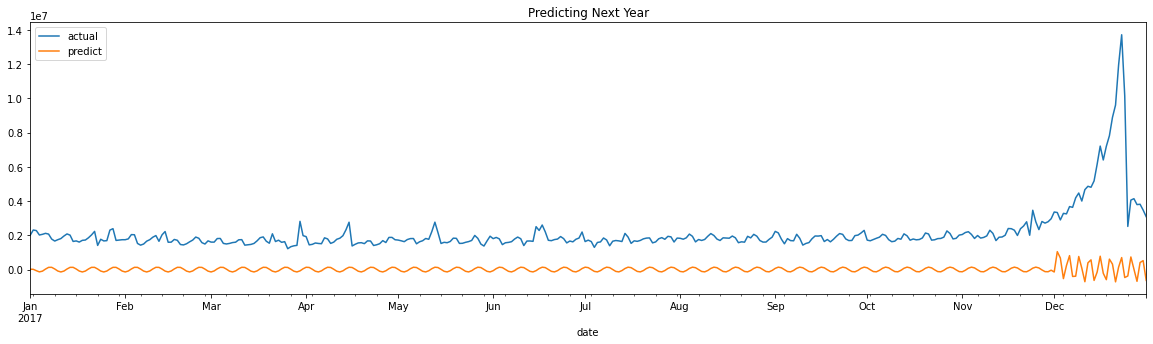

In [17]:
plot_next_year(df11_2016, df12_2016, df11_2017, df12_2017, 365, 2, (4, 1, 3))

C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so

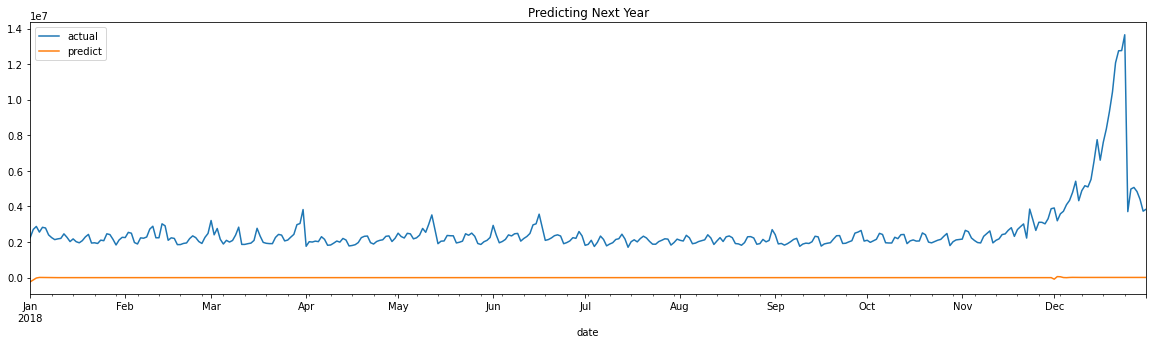

In [18]:
df11_2017t   = df11_2016.append(df11_2017)
df12_2017t   = df12_2016.append(df12_2017)

plot_next_year(df11_2017t, df12_2017t, df11_2018, df12_2018, 365, 2, (2, 1, 1))

C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so

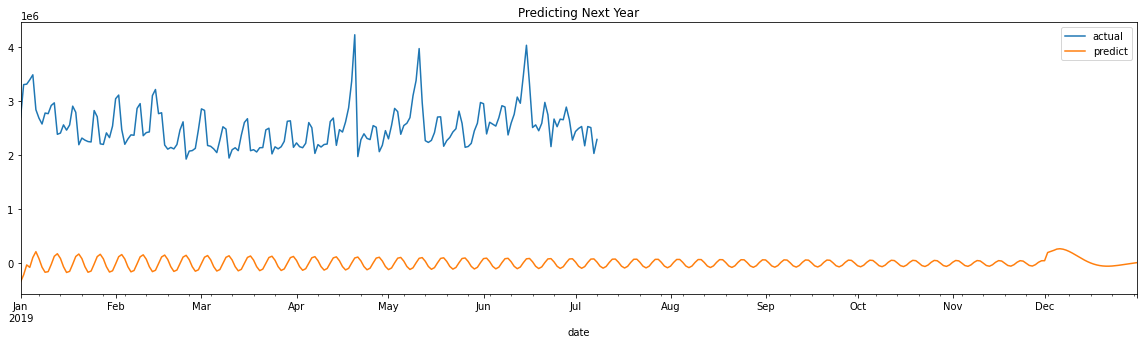

In [19]:
df11_2018t   = df11_2016.append(df11_2017)
df11_2018t   = df11_2018t.append(df11_2018)

df12_2018t   = df12_2016.append(df12_2017)
df12_2018t   = df12_2018t.append(df12_2018)

plot_next_year(df11_2018t, df12_2018t, df11_2019, df12_2019, 365, 2, (4, 1, 2))

#### Plot prediction of successive year using Seasonal ARIMA Model

C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was

9101.25377835802
958.6984212712082


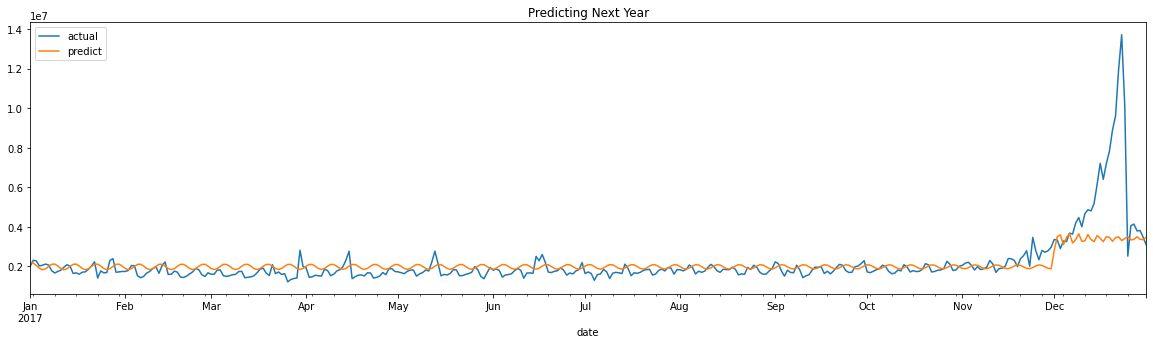

In [20]:
plot_next_year(df11_2016, df12_2016, df11_2017, df12_2017, 365, 3, (4, 1, 3))

C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


18359.409549745415
1923.0759091994155


C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


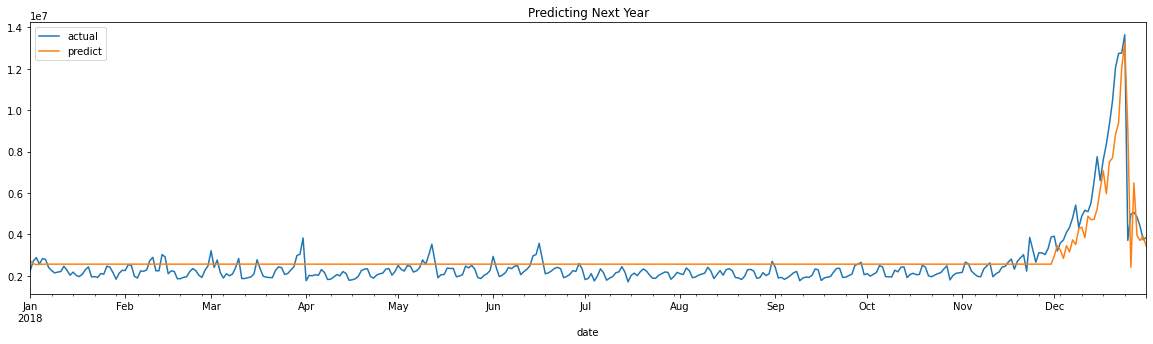

In [21]:
df11_2017t   = df11_2016.append(df11_2017)
df12_2017t   = df12_2016.append(df12_2017)

plot_next_year(df11_2017t, df12_2017t, df11_2018, df12_2018, 365, 3, (2, 1, 1))

C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


27566.553244301183


C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum L

2914.329237590148


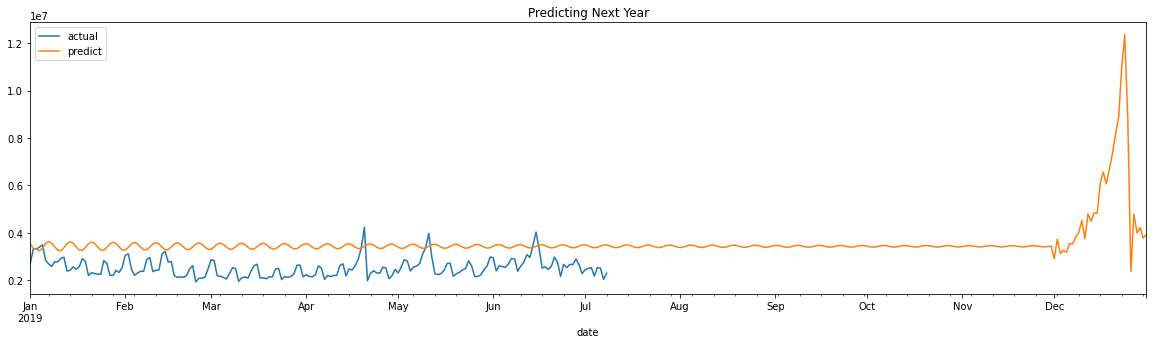

In [22]:
df11_2018t   = df11_2016.append(df11_2017)
df11_2018t   = df11_2018t.append(df11_2018)

df12_2018t   = df12_2016.append(df12_2017)
df12_2018t   = df12_2018t.append(df12_2018)

plot_next_year(df11_2018t, df12_2018t, df11_2019, df12_2019, 365, 3, (4, 1, 2))

#### Parameter Tuning

C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warn

32787.49742372884


C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2915.618614514844


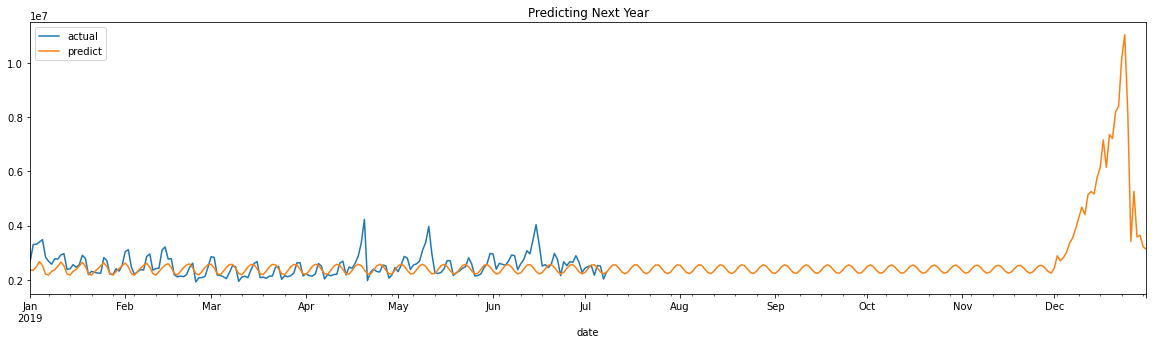

In [23]:
df11_2019t   = df11_2016.append(df11_2017)
df11_2019t   = df11_2019t.append(df11_2018)
df11_2019t   = df11_2019t.append(df11_2019)

df12_2019t   = df12_2016.append(df12_2017)
df12_2019t   = df12_2019t.append(df12_2018)
df12_2019t   = df12_2019t.append(df12_2019)

plot_next_year(df11_2019t, df12_2019t, df11_2019, df12_2019, 365, 3, (4, 1, 6))

C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


32766.289215210127


C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum L

2919.5376624025066


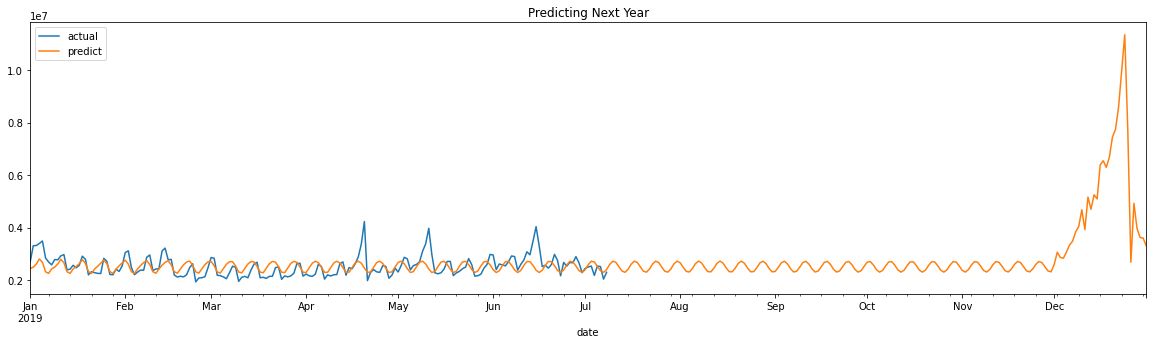

In [24]:
plot_next_year(df11_2019t, df12_2019t, df11_2019, df12_2019, 365, 3, (4, 1, 8))

C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warn

32777.799715072164


C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2915.1284099221325


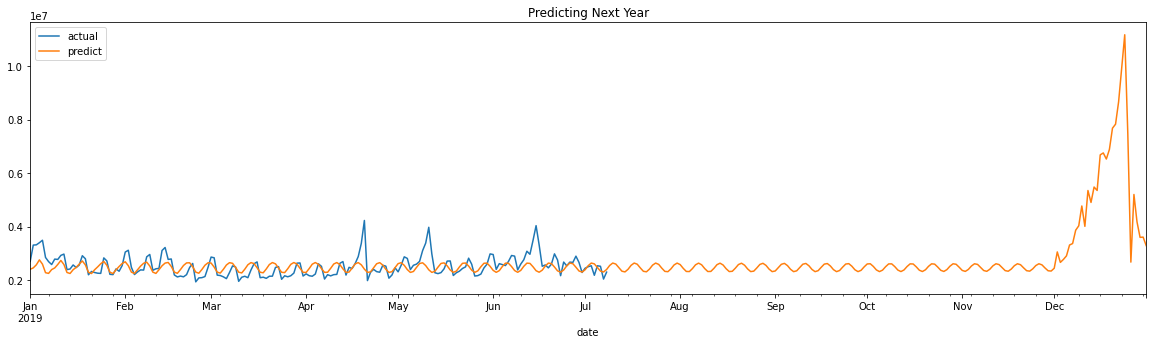

In [25]:
plot_next_year(df11_2019t, df12_2019t, df11_2019, df12_2019, 365, 3, (4, 1, 7))

C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


32676.258854475796


C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum L

2931.195944030791


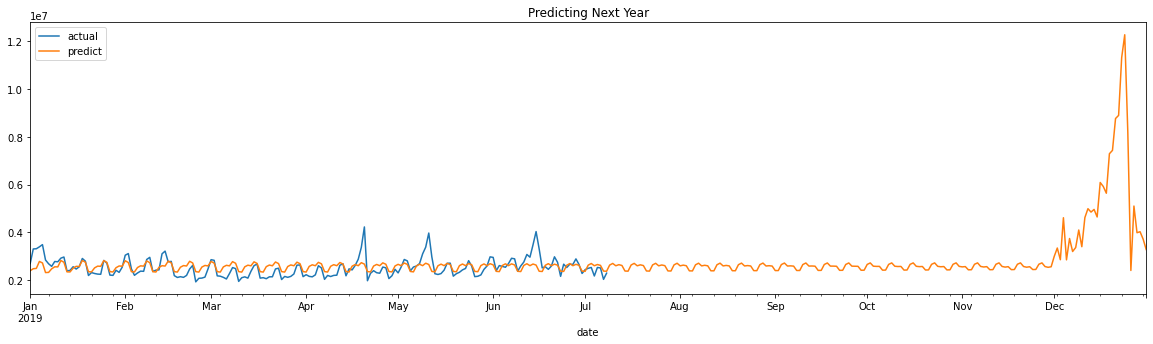

In [26]:
plot_next_year(df11_2019t, df12_2019t, df11_2019, df12_2019, 365, 3, (8, 1, 10))

C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


32680.812413264437


C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum L

2927.4919595719093


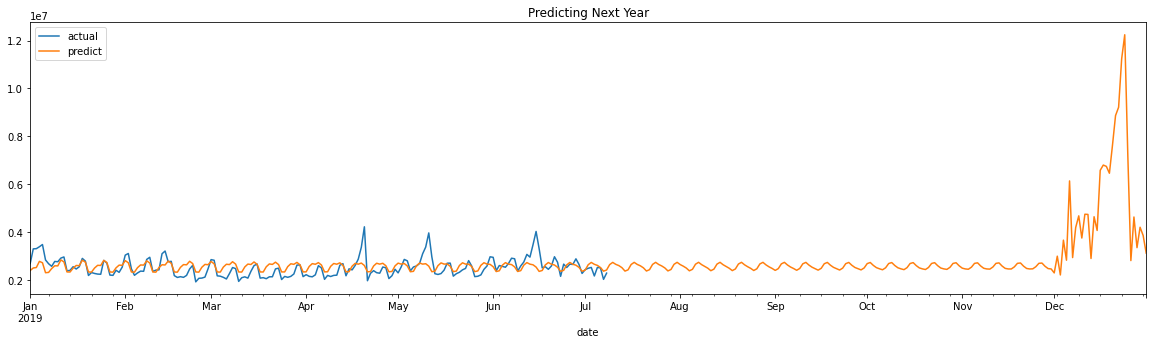

In [27]:
plot_next_year(df11_2019t, df12_2019t, df11_2019, df12_2019, 365, 3, (8, 1, 12))

In [30]:
# Future Predictions
from pandas.tseries.offsets import DateOffset

temp_df = df.copy()

number_of_days_in_future = 10
future_dates = [temp_df.index[-1]+DateOffset(months=x) for x in range(number_of_days_in_future)]
future_dates = pd.DataFrame(index=future_dates[1:],columns=['a'])#columns = df.columns)
future_dataset = pd.concat([temp_df, future_dates])
future_dataset.tail(12)


,Sales,a
2019-07-06,2510980.0,NaN
2019-07-07,2032842.0,NaN
2019-07-08,2291760.0,NaN
2019-08-08,NaN,NaN
2019-09-08,NaN,NaN
2019-10-08,NaN,NaN
2019-11-08,NaN,NaN
2019-12-08,NaN,NaN
2020-01-08,NaN,NaN
2020-02-08,NaN,NaN


In [118]:
def check_aic(dfs, p, d, q):
    s_arima_model = sm.tsa.statespace.SARIMAX(dfs, order=(p, d, q), seasonal_orders=(p, d, q, 1))        
    s_arima_fit   = s_arima_model.fit()    
    return s_arima_fit.aic

def predict_series(s_arima_fit, start_point, end_point):        
    return s_arima_fit.predict(start = start_point, end = end_point)#, dynamic=True)


# Find Best Value of p and q for Seasonal ARIMA
def find_best_pq(dfs, shift):
    best_aic, p_best, q_best = 9999999999, 1, 1
    for p_ in range(1,5):
        for q_ in range(5,9):

            p,d,q,start_point, end_point = 4,shift,8, 100, 1000            
            aic = check_aic(dfs, p, d, q)
            if aic < best_aic:
                best_aic, p_best, q_best = aic, p, q
    return best_aic, p_best, q_best


In [119]:
aic_11, p_11, q_11 = find_best_pq(df11_2019t,1)
aic_12, p_12, q_12 = find_best_pq(df12_2019t,0)

print('PQ for 11:', p_11, q_11)
print('PQ for 12:', p_12, q_12)

C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. fore

C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed t

C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed t

PQ for 11: 4 8
PQ for 12: 4 8


C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


In [133]:

s_arima_model_11 = sm.tsa.statespace.SARIMAX(df11_2019t, order=(p_11, 1, q_11), seasonal_orders=(p_11, 1, q_11, 1))        
s_arima_fit_11   = s_arima_model_11.fit()    
    
s_arima_model_12 = sm.tsa.statespace.SARIMAX(df12_2019t, order=(p_12, 0, q_12), seasonal_orders=(p_12, 0, q_12, 0))        
s_arima_fit_12   = s_arima_model_12.fit()        


C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. fore

### Predict until End of Year 2019

In [134]:
# Remaining Days to predict
r_days = 365-(df11_2019.shape[0]+df12_2019.shape[0])
r_days_11, r_days_12 = r_days - 31, 31 


# Predict for January to November
temp_df = pd.DataFrame()
temp1 = predict_series(s_arima_fit_11, 0, 1191+r_days_11)
temp_df['date']    = df11_2019t.index
temp_df['predict'] = temp1[:-r_days_11,]
temp_df.set_index('date', inplace=True)


# Predict for December
temp_df2 = pd.DataFrame()
temp2 = predict_series(s_arima_fit_12, 0, 92+r_days_12)
temp_df2['date']    = df12_2019t.index
temp_df2['predict'] = temp2[:-r_days_12,]
temp_df2.set_index('date', inplace=True)

# Previous data
previous_data = temp_df.append(temp_df2)


# Future Data
temp_a = temp1[-r_days_11:,]
temp_b = temp2[-r_days_12:,]


C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\Joe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


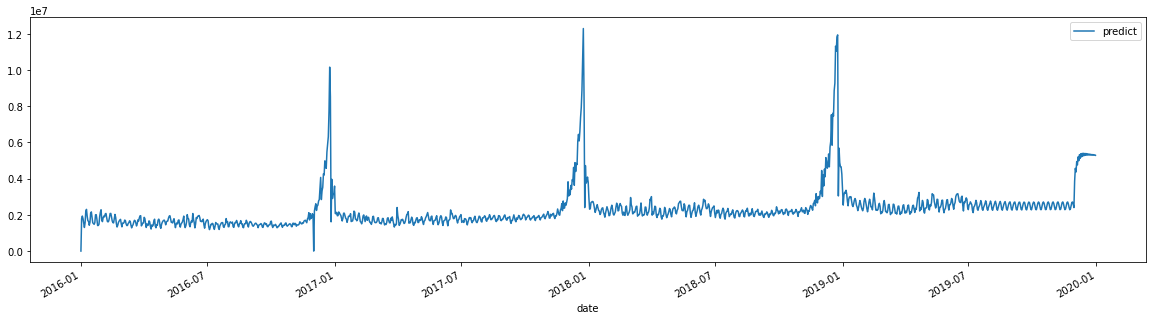

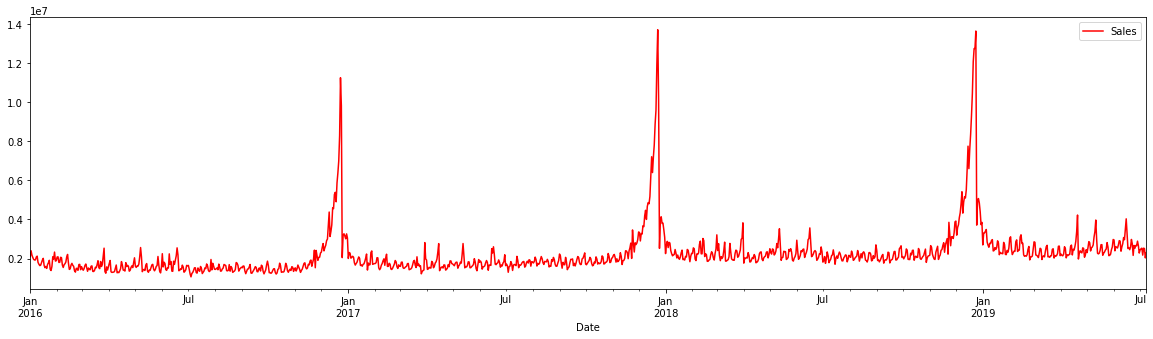

In [135]:
temp_df = pd.DataFrame()
temp_df['predict'] = (list(temp_a) + list(temp_b))
temp_df['date']    = [pd.to_datetime('2019-07-08') + DateOffset(days = x) for x in range(1, 177)]
temp_df.set_index('date', inplace=True)


total_data = previous_data.append(temp_df)
total_data.plot(figsize=(20,5))
df.plot(color='red',figsize=(20,5))


In [143]:
total_data.to_excel('output_arima.xlsx')
total_data[(total_data.index.month>6) &(total_data.index.year==2019)].head(30)

,predict
date,
2019-07-01,2.288737e+06
2019-07-02,2.549720e+06
2019-07-03,2.595759e+06
2019-07-04,2.717536e+06
2019-07-05,2.639309e+06
2019-07-06,2.557580e+06
2019-07-07,2.244117e+06
2019-07-08,2.122207e+06
2019-07-09,2.434841e+06
